In [4]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from gm_function import *

In [5]:
#PATH 

initial_path = '../CreateStudy'

# Change this value
participant_id = 'S001'
dominant_hand = 'Right'

# Join the initial_path and participant_id
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\S001


In [6]:
# Get the data from csv files 
ndh_data, chest_data, dh_data, GT_mask_ndh, GT_mask_dh = get_data(participant_path, dominant_hand)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_ndh)*2, len(ndh_data))

61706 61706


In [7]:
# Get some usefull variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz

In [8]:
# Get AC values 
AC_ndh_filename = 'count_brond_ndh.csv'
AC_dh_filename = 'count_brond_dh.csv'

AC_ndh_path = os.path.join(participant_path, AC_ndh_filename)
AC_dh_path = os.path.join(participant_path, AC_dh_filename)

AC_ndh, AC_dh = read_csv_to_numpy(AC_ndh_path, AC_dh_path)

In [9]:
# MASK with WBM replaced by NF #

In [10]:
# Create masks with WBM converted into NF movement

GT_mask_ndh_1Hz = downsample_mask_interpolation(GT_mask_ndh, FPS_mask, frequency_AC)
GT_mask_dh_1Hz = downsample_mask_interpolation(GT_mask_dh, FPS_mask, frequency_AC)
GT_mask_ndh_2Hz = downsample_mask_interpolation(GT_mask_ndh, FPS_mask, frequency_GM)
GT_mask_dh_2Hz = downsample_mask_interpolation(GT_mask_dh, FPS_mask, frequency_GM)

# Replace WBM mask by NF masks @ 25Hz 
GT_mask_ndh_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh).ravel()
GT_mask_dh_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh).ravel()

# Replace WBM mask by NF masks @ 2Hz 
GT_mask_ndh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_2Hz)
GT_mask_dh_2Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_2Hz)

# Replace WBM mask by NF masks @ 1Hz 
GT_mask_ndh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_ndh_1Hz)
GT_mask_dh_1Hz_wbm_into_nf = replace_wbm_with_nf(GT_mask_dh_1Hz)

# Trim dataset to ensure same size 
GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh = remove_extra_elements(GT_mask_ndh_1Hz_wbm_into_nf, AC_ndh)
GT_mask_dh_1Hz_wbm_into_nf, AC_dh = remove_extra_elements(GT_mask_dh_1Hz_wbm_into_nf, AC_dh)

# Upsample the masks 
GT_mask_50Hz_ndh = resample_mask(GT_mask_ndh_wbm_into_nf, 25.0, 50.0)
GT_mask_50Hz_dh = resample_mask(GT_mask_dh_wbm_into_nf, 25.0, 50.0)

In [11]:
## GM 

In [12]:
# Get Euler angles 

# Left wrist
roll_mad_ndh, pitch_mad_ndh, yaw_mad_ndh = compute_euler_angles(acc_ndh, gyro_ndh, sampling_freq)
#plot_angles_over_time(pitch_mad_ndh), plot_angles_over_time(yaw_mad_ndh)

# Right wrist 
roll_mad_dh, pitch_mad_dh, yaw_mad_dh = compute_euler_angles(acc_dh, gyro_dh, sampling_freq)
#plot_angles_over_time(pitch_mad_dh), plot_angles_over_time(yaw_mad_dh)

Using IMU Madgwick with acc and gyro only
Using IMU Madgwick with acc and gyro only


In [13]:
# Ensure the datasets have the same sizes 
# For ndh
pitch_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(pitch_mad_ndh, GT_mask_50Hz_ndh)
yaw_mad_ndh, GT_mask_50Hz_ndh = remove_extra_elements(yaw_mad_ndh, GT_mask_50Hz_ndh)

# For dh
pitch_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(pitch_mad_dh, GT_mask_50Hz_dh)
yaw_mad_dh, GT_mask_50Hz_dh = remove_extra_elements(yaw_mad_dh, GT_mask_50Hz_dh)

In [14]:
# Save the datasets as CSV files 
save_gm_arrays_as_csv(pitch_mad_ndh, yaw_mad_ndh, pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_ndh, GT_mask_50Hz_dh, participant_path)

CSV file saved successfully.
CSV saved at: ../CreateStudy\S001\gm_datasets.csv


In [15]:
# Computation of an optimal FS for the GM algorithm # 

In [16]:
# Optimal Left wrist 
eval_metrics_fs_opt_ndh, optimal_fs_ndh = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                                               k=5, random_state=42, optimal=True)

# Conventional Left wrist 
eval_metrics_fs_conv_ndh, _ = optimal_fs_computation(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                                    k=5, random_state=42, optimal=False)

In [17]:
# Optimal Right wrist 
eval_metrics_fs_opt_dh, optimal_fs_dh = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                                               k=5, random_state=42, optimal=True)

# Conventional Right wrist 
eval_metrics_fs_conv_dh, _ = optimal_fs_computation(pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                                    k=5, random_state=42, optimal=False)

In [18]:
# Optimal Bilateral 
eval_metrics_fs_opt_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=True)

# Conventional Bilateral 
eval_metrics_fs_conv_bil = optimal_fs_computation_bilateral(pitch_mad_ndh, yaw_mad_ndh, GT_mask_50Hz_ndh,
                                     pitch_mad_dh, yaw_mad_dh, GT_mask_50Hz_dh,
                                     optimal_fs_ndh, optimal_fs_dh,k=5, random_state=42, optimal=False)

In [19]:
print(optimal_fs_ndh, optimal_fs_dh)

55.0 51.0


In [20]:
eval_metrics_fs_conv_bil

{'Sensitivity': 57.42958515844666,
 'Specificity': 73.73612346688253,
 'Accuracy': 63.935091277890464,
 'PPV': 76.73625530172488,
 'NPV': 53.46194615032764,
 'F1 Score': 65.69261680008537,
 'Youden Index': 31.165708625329195}

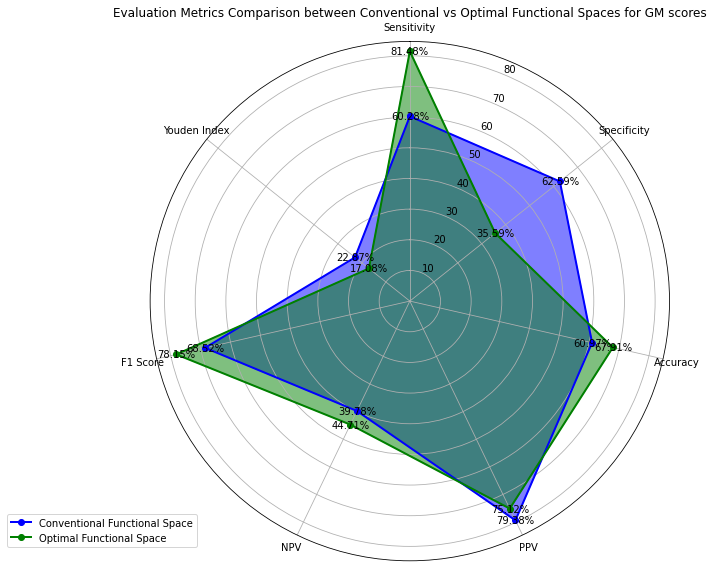

In [21]:
plot_radar_chart(eval_metrics_fs_conv_ndh, eval_metrics_fs_opt_ndh, metric = 'GM')

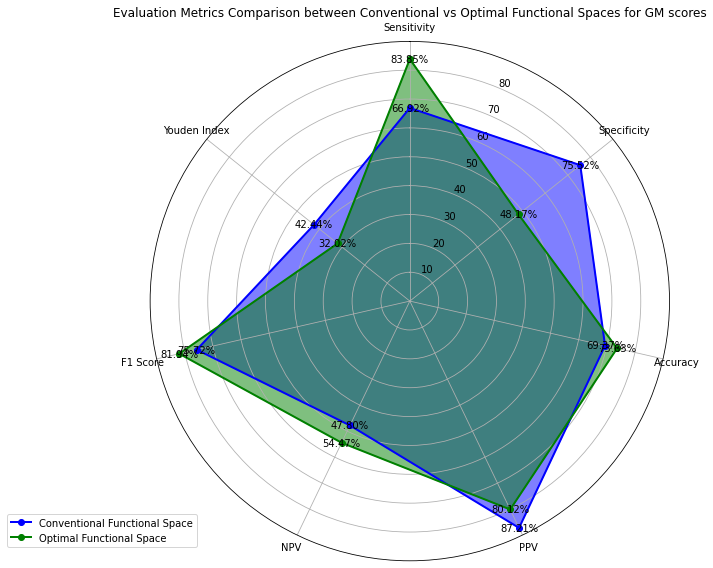

In [22]:
plot_radar_chart(eval_metrics_fs_conv_dh, eval_metrics_fs_opt_dh, metric = 'GM')

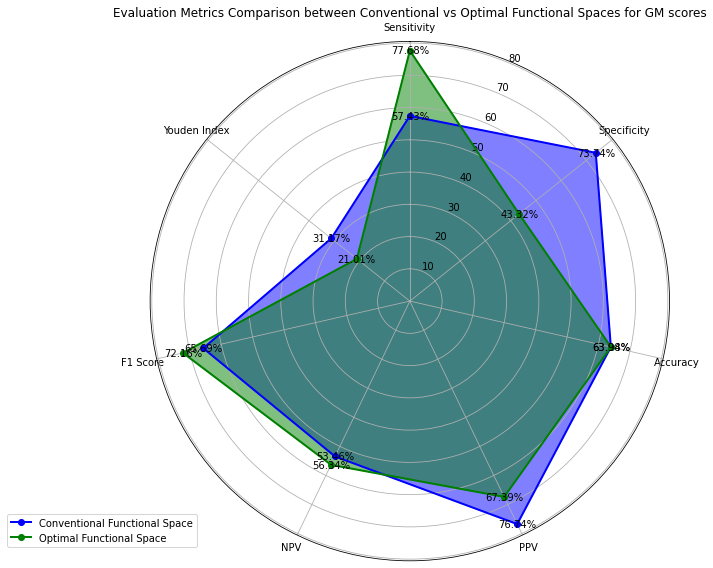

In [23]:
plot_radar_chart(eval_metrics_fs_conv_bil, eval_metrics_fs_opt_bil, metric = 'GM')

In [24]:
# Saving data for this participant 

In [25]:
# Create a structure to save all the metrics 
metrics_dictionary_GM = create_metrics_dictionary(eval_metrics_fs_conv_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_conv_bil, eval_metrics_fs_opt_ndh, eval_metrics_fs_conv_dh, eval_metrics_fs_opt_bil)

In [26]:
metrics_dictionary_GM

{('OT_ndh', 'Sensitivity'): 81.48348774986223,
 ('OT_ndh', 'Specificity'): 35.592024979369185,
 ('OT_ndh', 'Accuracy'): 67.91075050709938,
 ('OT_ndh', 'PPV'): 75.1161557850763,
 ('OT_ndh', 'NPV'): 44.71090035870524,
 ('OT_ndh', 'F1 Score'): 78.15295421097598,
 ('OT_ndh', 'Youden Index'): 17.07551272923139,
 ('OT_dh', 'Sensitivity'): 66.91783549493128,
 ('OT_dh', 'Specificity'): 75.51979942694108,
 ('OT_dh', 'Accuracy'): 69.3711967545639,
 ('OT_dh', 'PPV'): 87.20648922379645,
 ('OT_dh', 'NPV'): 47.8016842691671,
 ('OT_dh', 'F1 Score'): 75.71727691614626,
 ('OT_dh', 'Youden Index'): 42.43763492187236,
 ('OT_bilateral', 'Sensitivity'): 77.68464553131204,
 ('OT_bilateral', 'Specificity'): 43.32264191772258,
 ('OT_bilateral', 'Accuracy'): 63.975659229208915,
 ('OT_bilateral', 'PPV'): 67.38778252882885,
 ('OT_bilateral', 'NPV'): 56.3388155426372,
 ('OT_bilateral', 'F1 Score'): 72.16257849487927,
 ('OT_bilateral', 'Youden Index'): 21.007287449034617,
 ('CT_ndh', 'Sensitivity'): 60.28218719060

In [27]:
# Save metrics as csv file: evaluation metrics on unseen data 
save_metrics_dictionary_as_csv(metrics_dictionary_GM, participant_path, metric = 'GM')
# Save optimal AC threhshold for this participant 
save_optimal_threshold(participant_path, optimal_fs_ndh, optimal_fs_dh, AC = False)

The metrics dictionary has been saved as ../CreateStudy\S001\evaluation_metrics_GM.csv.
Thresholds saved successfully at: ../CreateStudy\S001\optimal_threshold_GM.csv


In [28]:
# GMAC # 

In [29]:
AC_ndh, AC_dh

(array([257.45096621, 182.67457404,  81.04936767, ..., 261.69638897,
        165.6351412 , 147.41438193]),
 array([174.82848738, 195.05383872, 196.24984076, ..., 278.88528107,
        321.73591655, 417.94018711]))

In [30]:
opt_ac_threshold_ndh, opt_ac_threshold_dh = load_optimal_threshold(participant_path)

Thresholds loaded successfully from: ../CreateStudy\S001\optimal_threshold_AC.csv


In [31]:
# For the NDH 
gmac_ndh_conv = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_ndh = get_evaluation_metrics(GT_mask_ndh_1Hz_wbm_into_nf, gmac_ndh_conv)

gmac_ndh_opt = compute_GMAC(pitch_mad_ndh, AC_ndh, ac_threshold = opt_ac_threshold_ndh, functional_space = optimal_fs_ndh)
eval_metrics_gmac_opt_ndh = get_evaluation_metrics(GT_mask_ndh_1Hz_wbm_into_nf, gmac_ndh_opt)

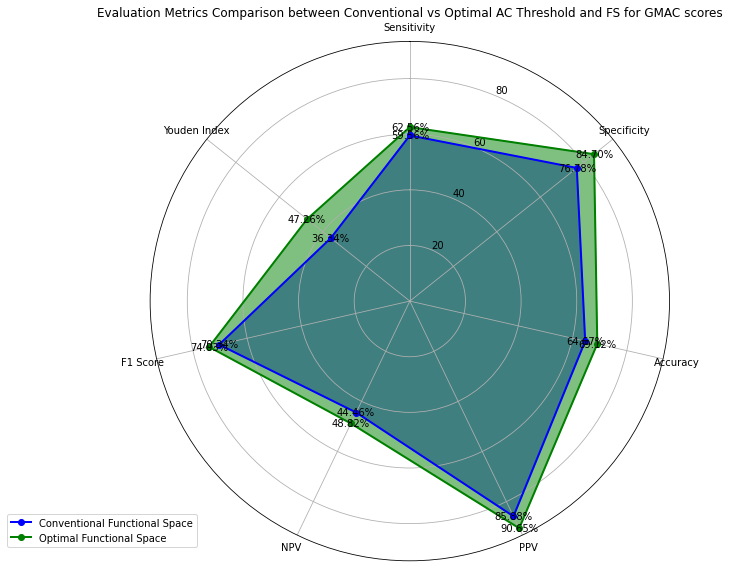

In [32]:
plot_radar_chart(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_opt_ndh, metric = 'GMAC')

In [33]:
# For the DH 
gmac_dh_conv = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = 0, functional_space = 30)
eval_metrics_gmac_conv_dh = get_evaluation_metrics(GT_mask_dh_1Hz_wbm_into_nf, gmac_dh_conv)

gmac_dh_opt = compute_GMAC(pitch_mad_dh, AC_dh, ac_threshold = opt_ac_threshold_dh, functional_space = optimal_fs_dh)
eval_metrics_gmac_opt_dh = get_evaluation_metrics(GT_mask_dh_1Hz_wbm_into_nf, gmac_dh_opt)

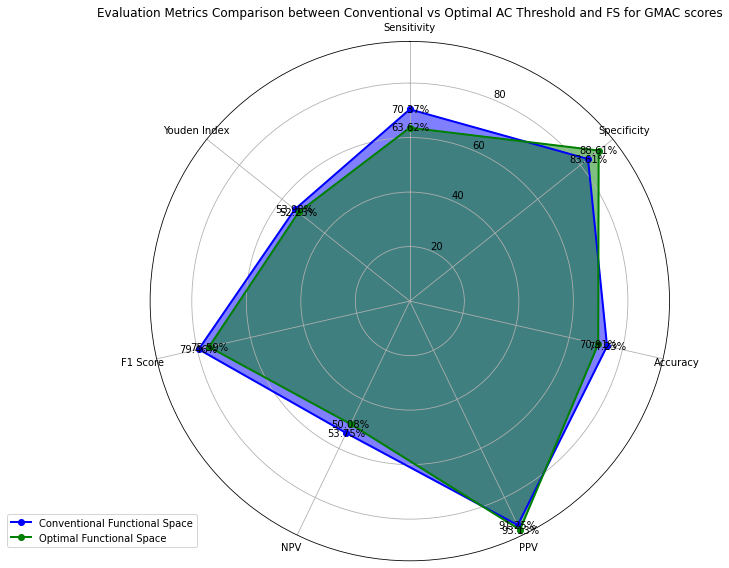

In [34]:
plot_radar_chart(eval_metrics_gmac_conv_dh, eval_metrics_gmac_opt_dh, metric = 'GMAC')

In [35]:
# For the bilateral usage 
# Use a simple logical AND 
# Mask 
GT_mask_bil_1Hz = get_mask_bilateral(GT_mask_ndh_1Hz_wbm_into_nf, GT_mask_dh_1Hz_wbm_into_nf)

# Conv
gmac_bil_conv = get_mask_bilateral(gmac_ndh_conv, gmac_dh_conv)
eval_metrics_gmac_conv_bil = get_evaluation_metrics(GT_mask_bil_1Hz, gmac_bil_conv)

# Opti
gmac_bil_opt = get_mask_bilateral(gmac_ndh_opt, gmac_dh_opt)
eval_metrics_gmac_opt_bil = get_evaluation_metrics(GT_mask_bil_1Hz, gmac_bil_opt)

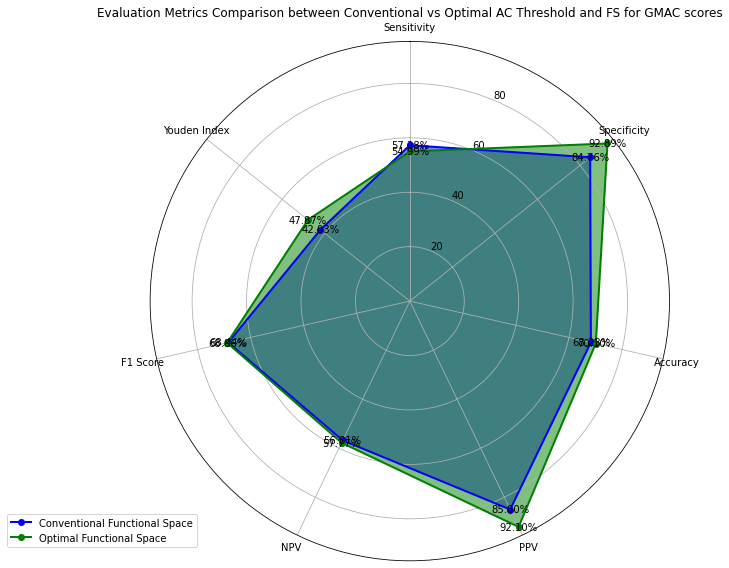

In [36]:
plot_radar_chart(eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_bil, metric = 'GMAC')

In [37]:
# Create a structure to save all the metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_gmac_conv_ndh, eval_metrics_gmac_conv_dh, eval_metrics_gmac_conv_bil, eval_metrics_gmac_opt_ndh, eval_metrics_gmac_opt_dh, eval_metrics_gmac_opt_bil)
metrics_dictionary_GMAC

{('OT_ndh', 'Sensitivity'): 62.55760368663594,
 ('OT_ndh', 'Specificity'): 84.69945355191257,
 ('OT_ndh', 'Accuracy'): 69.12479740680712,
 ('OT_ndh', 'PPV'): 90.65108514190318,
 ('OT_ndh', 'NPV'): 48.818897637795274,
 ('OT_ndh', 'F1 Score'): 74.02862985685071,
 ('OT_ndh', 'Youden Index'): 47.25705723854852,
 ('OT_dh', 'Sensitivity'): 63.61556064073226,
 ('OT_dh', 'Specificity'): 88.61111111111111,
 ('OT_dh', 'Accuracy'): 70.90761750405187,
 ('OT_dh', 'PPV'): 93.1323283082077,
 ('OT_dh', 'NPV'): 50.078492935635786,
 ('OT_dh', 'F1 Score'): 75.59483344663494,
 ('OT_dh', 'Youden Index'): 52.22667175184337,
 ('OT_bilateral', 'Sensitivity'): 54.98652291105122,
 ('OT_bilateral', 'Specificity'): 92.88617886178862,
 ('OT_bilateral', 'Accuracy'): 70.097244732577,
 ('OT_bilateral', 'PPV'): 92.09932279909707,
 ('OT_bilateral', 'NPV'): 57.77496839443742,
 ('OT_bilateral', 'F1 Score'): 68.86075949367088,
 ('OT_bilateral', 'Youden Index'): 47.87270177283985,
 ('CT_ndh', 'Sensitivity'): 59.56221198156

In [38]:
# Save individual eval metrics for GMAC scores 
save_metrics_dictionary_as_csv(metrics_dictionary_GMAC, participant_path, metric='GMAC')

The metrics dictionary has been saved as ../CreateStudy\S001\evaluation_metrics_GMAC.csv.
